Install the Deep DNAshape package from https://github.com/JinsenLi/deepDNAshape to obtain
DNA shape features for the input files Max.txt, Mad.txt, and Myc.txt. Generate a feature vector
for “1-mer” sequence model, a feature vector for “2-mer” sequence model and a feature vector
for “1-mer+shape” model for each of the datasets corresponding to Mad, Max and Myc. [2pt]

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def one_hot_encode_dna(sequence, kmer=1):
    encoding_map_1mer = {'A': '1000', 'C': '0100', 'G': '0010', 'T': '0001'}
    encoding_map_2mer = {
    'AA': '1000000000000000', 'AC': '0100000000000000', 'AG': '0010000000000000', 'AT': '0001000000000000',
    'CA': '0000100000000000', 'CC': '0000010000000000', 'CG': '0000001000000000', 'CT': '0000000100000000',
    'GA': '0000000010000000', 'GC': '0000000001000000', 'GG': '0000000000100000', 'GT': '0000000000010000',
    'TA': '0000000000001000', 'TC': '0000000000000100', 'TG': '0000000000000010', 'TT': '0000000000000001'
    }
    encoded_sequence = ''
    if kmer == 1:
        for nucleotide in sequence:
            encoded_sequence += encoding_map_1mer[nucleotide]
    elif kmer == 2:
        for i in range(len(sequence) - 1):
            dinucleotide = sequence[i:i + 2]
            encoded_sequence += encoding_map_2mer[dinucleotide]
    return [int(item) for item in list(encoded_sequence)]

In [3]:
def parse_fasta(file_path, label):
    sequences = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith('>'):
                sequences.append((line.strip()))
    return pd.DataFrame({'sequence': sequences, 'label': label})

In [4]:
mad_df = pd.read_csv('Mad.txt', sep='\t', header=None, names=['sequence', 'affinity'])
max_df = pd.read_csv('Max.txt', sep='\t', header=None, names=['sequence', 'affinity'])
myc_df = pd.read_csv('Myc.txt', sep='\t', header=None, names=['sequence', 'affinity'])
ctcf_bound = parse_fasta('ctcf_bound.fasta', 1)
ctcf_unbound = parse_fasta('ctcf_unbound.fasta', 0)


mad_df['1mer'] = mad_df['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=1))
max_df['1mer'] = max_df['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=1))
myc_df['1mer'] = myc_df['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=1))
ctcf_bound['1mer'] = ctcf_bound['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=1))
ctcf_unbound['1mer'] = ctcf_unbound['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=1))
mad_df['2mer'] = mad_df['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=2))
max_df['2mer'] = max_df['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=2))
myc_df['2mer'] = myc_df['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=2))
ctcf_bound['2mer'] = ctcf_bound['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=2))
ctcf_unbound['2mer'] = ctcf_unbound['sequence'].apply(lambda x: one_hot_encode_dna(x, kmer=2))


mad_helt = np.array(pd.read_csv('Mad.HelT', delimiter=' ', header=None).values)
mad_mgw = np.array(pd.read_csv('Mad.MGW', delimiter=' ', header=None).values)
mad_prot = np.array(pd.read_csv('Mad.ProT', delimiter=' ', header=None).values)
mad_roll = np.array(pd.read_csv('Mad.Roll', delimiter=' ', header=None).values)
mad_all = np.concatenate([mad_helt, mad_mgw, mad_prot, mad_roll], axis=1)

max_helt = np.array(pd.read_csv('Max.HelT', delimiter=' ', header=None).values)
max_mgw = np.array(pd.read_csv('Max.MGW', delimiter=' ', header=None).values)
max_prot = np.array(pd.read_csv('Max.ProT', delimiter=' ', header=None).values)
max_roll = np.array(pd.read_csv('Max.Roll', delimiter=' ', header=None).values)
max_all = np.concatenate([max_helt, max_mgw, max_prot, max_roll], axis=1)

myc_helt = np.array(pd.read_csv('Myc.HelT', delimiter=' ', header=None).values)
myc_mgw = np.array(pd.read_csv('Myc.MGW', delimiter=' ', header=None).values)
myc_prot = np.array(pd.read_csv('Myc.ProT', delimiter=' ', header=None).values)
myc_roll = np.array(pd.read_csv('Myc.Roll', delimiter=' ', header=None).values)
myc_all = np.concatenate([myc_helt, myc_mgw, myc_prot, myc_roll], axis=1)

ctcf_bound_helt = np.array(pd.read_csv('ctcf_bound.HelT', delimiter=' ', header=None).values)
ctcf_bound_mgw = np.array(pd.read_csv('ctcf_bound.MGW', delimiter=' ', header=None).values)
ctcf_bound_prot = np.array(pd.read_csv('ctcf_bound.ProT', delimiter=' ', header=None).values)
ctcf_bound_roll = np.array(pd.read_csv('ctcf_bound.Roll', delimiter=' ', header=None).values)
ctcf_bound_all = np.concatenate([ctcf_bound_helt, ctcf_bound_mgw, ctcf_bound_prot, ctcf_bound_roll], axis=1)

ctcf_unbound_helt = np.array(pd.read_csv('ctcf_unbound.HelT', delimiter=' ', header=None).values)
ctcf_unbound_mgw = np.array(pd.read_csv('ctcf_unbound.MGW', delimiter=' ', header=None).values)
ctcf_unbound_prot = np.array(pd.read_csv('ctcf_unbound.ProT', delimiter=' ', header=None).values)
ctcf_unbound_roll = np.array(pd.read_csv('ctcf_unbound.Roll', delimiter=' ', header=None).values)
ctcf_unbound_all = np.concatenate([ctcf_unbound_helt, ctcf_unbound_mgw, ctcf_unbound_prot, ctcf_unbound_roll], axis=1)

ctcf_seqs = pd.concat([ctcf_bound, ctcf_unbound], ignore_index=True)
ctcf_all = np.concatenate([ctcf_bound_all, ctcf_unbound_all], axis=0)

Build L2-regularized multiple linear regression (MLR) models for “1-mer”, “2-mer” and
“1-mer+shape” features with 10-fold cross validation. Calculate and report the average R2
(coefficient of determination) for each of these three models across the datasets of Mad, Max
and Myc. [2pt]

In [5]:
def train_1mer_model(name, df):
    # Define the cross-validation
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    
    # Define the Lasso regression model
    model_1mer = Ridge(alpha=0.001)
    
    # Results list
    mse_1mer_scores = []
    r_squared_1mer_scores = []
    
    # Prepare the feature vectors
    X_1mer = np.array(df['1mer'].tolist())
    y = np.array(df['affinity'])
    
    # Loop over each fold
    fold = 1
    for train_index, valid_index in cv.split(y):
        # Split data
        X_1mer_train, X_1mer_valid = X_1mer[train_index], X_1mer[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        # Fit the models
        model_1mer.fit(X_1mer_train, y_train)
        
        # Predict on valid set
        predictions_1mer = model_1mer.predict(X_1mer_valid)
        
        # Evaluate the models
        mse_1mer = mean_squared_error(y_valid, predictions_1mer)
        mse_1mer_scores.append(mse_1mer)
        r_squared_1mer = r2_score(y_valid, predictions_1mer)
        r_squared_1mer_scores.append(r_squared_1mer)
    
        fold += 1

    # Print the average MSE and R² scores
    print(f"Average MSE for {name} 1-mer model:", np.mean(mse_1mer_scores))
    print(f"Average R² for {name} 1-mer model:", np.mean(r_squared_1mer_scores))
    return r_squared_1mer_scores

In [6]:
max_1mer = train_1mer_model('Max', max_df)
mad_1mer = train_1mer_model('Mad', mad_df)
myc_1mer = train_1mer_model('Myc', myc_df)

Average MSE for Max 1-mer model: 0.009856952408410283
Average R² for Max 1-mer model: 0.7845132686317624
Average MSE for Mad 1-mer model: 0.1445733128670705
Average R² for Mad 1-mer model: 0.7738834550439663
Average MSE for Myc 1-mer model: 0.13926821195057987
Average R² for Myc 1-mer model: 0.7779846788408208


In [7]:
def train_2mer_model(name, df):
    # Define the cross-validation
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    
    # Define the Lasso regression model
    model_2mer = Ridge(alpha=0.001)
    
    # Results list
    mse_2mer_scores = []
    r_squared_2mer_scores = []
    
    # Prepare the feature vectors
    X_2mer = np.array(df['2mer'].tolist())
    y = np.array(df['affinity'])
    
    # Loop over each fold
    fold = 1
    for train_index, valid_index in cv.split(y):
        # Split data
        X_2mer_train, X_2mer_valid = X_2mer[train_index], X_2mer[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        # Fit the models
        model_2mer.fit(X_2mer_train, y_train)
        
        # Predict on valid set
        predictions_2mer = model_2mer.predict(X_2mer_valid)
        
        # Evaluate the models
        mse_2mer = mean_squared_error(y_valid, predictions_2mer)
        mse_2mer_scores.append(mse_2mer)
        r_squared_2mer = r2_score(y_valid, predictions_2mer)
        r_squared_2mer_scores.append(r_squared_2mer)
    
        fold += 1

    # Print the average MSE and R² scores
    print(f"Average MSE for {name} 2-mer model:", np.mean(mse_2mer_scores))
    print(f"Average R² for {name} 2-mer model:", np.mean(r_squared_2mer_scores))
    return r_squared_2mer_scores

In [8]:
max_2mer = train_2mer_model('Max', max_df)
mad_2mer = train_2mer_model('Mad', mad_df)
myc_2mer = train_2mer_model('Myc', myc_df)

Average MSE for Max 2-mer model: 0.006185445746987692
Average R² for Max 2-mer model: 0.864720257819609
Average MSE for Mad 2-mer model: 0.09342512200002188
Average R² for Mad 2-mer model: 0.8538236792234107
Average MSE for Myc 2-mer model: 0.10381792615372012
Average R² for Myc 2-mer model: 0.8344220328411867


In [9]:
def train_shape_model(name, df, shape):
    # Define the cross-validation
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    
    # Define the Lasso regression model
    model_1mer_shape = Ridge(alpha=0.001)
    
    # Results list
    mse_1mer_shape_scores = []
    r_squared_1mer_shape_scores = []
    
    # Prepare the feature vectors
    X_1mer_shape = np.column_stack([df['1mer'].tolist(), shape])
    y = np.array(df['affinity'])
    
    # Loop over each fold
    fold = 1
    for train_index, valid_index in cv.split(y):
        # Split data
        X_1mer_shape_train, X_1mer_shape_valid = X_1mer_shape[train_index], X_1mer_shape[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        # Fit the models
        model_1mer_shape.fit(X_1mer_shape_train, y_train)
        
        # Predict on valid set
        predictions_1mer_shape = model_1mer_shape.predict(X_1mer_shape_valid)
        
        # Evaluate the models
        mse_1mer_shape = mean_squared_error(y_valid, predictions_1mer_shape)
        mse_1mer_shape_scores.append(mse_1mer_shape)
        r_squared_1mer_shape = r2_score(y_valid, predictions_1mer_shape)
        r_squared_1mer_shape_scores.append(r_squared_1mer_shape)
    
        fold += 1

    # Print the average MSE and R² scores
    print(f"Average MSE for {name} 1-mer+shape model:", np.mean(mse_1mer_shape_scores))
    print(f"Average R² for {name} 1-mer+shape model:", np.mean(r_squared_1mer_shape_scores))
    return r_squared_1mer_shape_scores
    

In [10]:
max_1mer_shape = train_shape_model('Max', max_df, max_all)
mad_1mer_shape = train_shape_model('Mad', mad_df, mad_all)
myc_1mer_shape = train_shape_model('Myc', myc_df, myc_all)

Average MSE for Max 1-mer+shape model: 0.0033193481503741955
Average R² for Max 1-mer+shape model: 0.9273563119349714
Average MSE for Mad 1-mer+shape model: 0.0325026167742027
Average R² for Mad 1-mer+shape model: 0.9491785934218256
Average MSE for Myc 1-mer+shape model: 0.05481425192228526
Average R² for Myc 1-mer+shape model: 0.9125729053614252


Generate two plots for a comparison of two different models: one comparing the “1mer” vs.
“1mer+shape” and another comparing the “2mer” vs. “1mer+shape” model. Make the plot in a
manner similar to that presented in Figure 1(B) of Zhou et al. PNAS 2015. Briefly discuss what
you have learned from the results. [2pt]

***The results indicate that the 1-mer+shape model is superior to both the 1-mer only and 2-mer only models. This is evidenced by the fact that the 1-mer+shape R^2 vs. 1-mer R^2 points all fall above the baseline. The baseline represents equal R^2 performance between the two models, and the fact that all the points fall above this line means that the 1mer+shape model obtains a superior R^2 value over the 1-mer only model in all trials. The same can be said for the 1-mer+shape model compared to the 2-mer model. This trend persists across all the protein families so we can conclude that that adding shape features allows the model to extract more pertinent features that allow for better performance.***

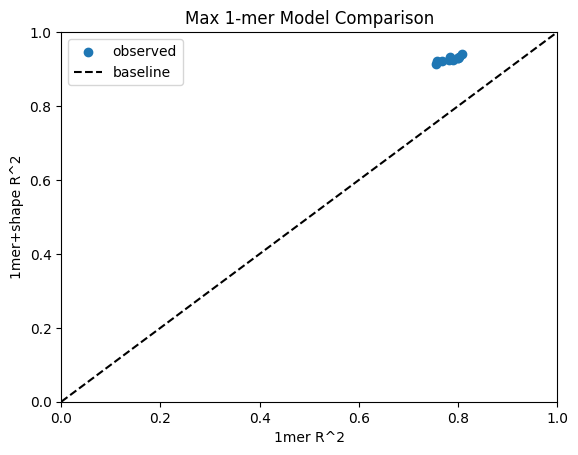

In [11]:
plt.scatter(max_1mer, max_1mer_shape, label='observed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('1mer R^2')
plt.ylabel('1mer+shape R^2')
plt.title('Max 1-mer Model Comparison')
plt.plot([0,1], [0,1], '--', color='black', label='baseline')
plt.legend()
plt.show()

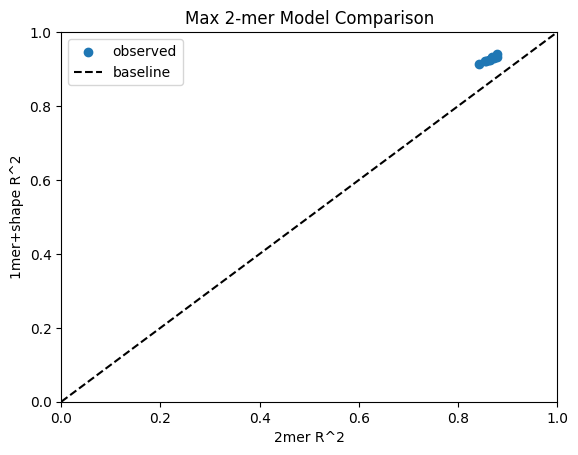

In [12]:
plt.scatter(max_2mer, max_1mer_shape, label='observed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('2mer R^2')
plt.ylabel('1mer+shape R^2')
plt.title('Max 2-mer Model Comparison')
plt.plot([0,1], [0,1], '--', color='black', label='baseline')
plt.legend()
plt.show()

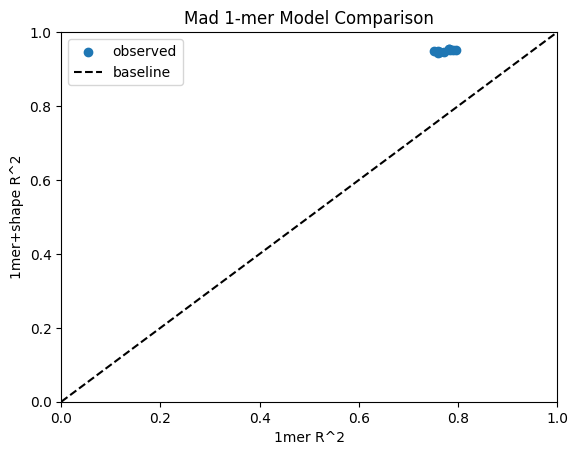

In [13]:
plt.scatter(mad_1mer, mad_1mer_shape, label='observed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('1mer R^2')
plt.ylabel('1mer+shape R^2')
plt.title('Mad 1-mer Model Comparison')
plt.plot([0,1], [0,1], '--', color='black', label='baseline')
plt.legend()
plt.show()

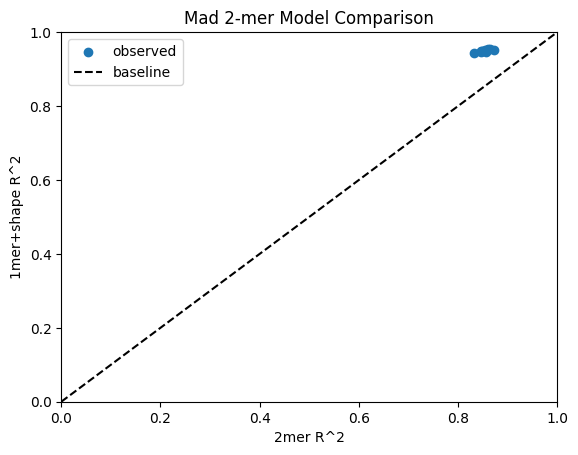

In [14]:
plt.scatter(mad_2mer, mad_1mer_shape, label='observed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('2mer R^2')
plt.ylabel('1mer+shape R^2')
plt.title('Mad 2-mer Model Comparison')
plt.plot([0,1], [0,1], '--', color='black', label='baseline')
plt.legend()
plt.show()

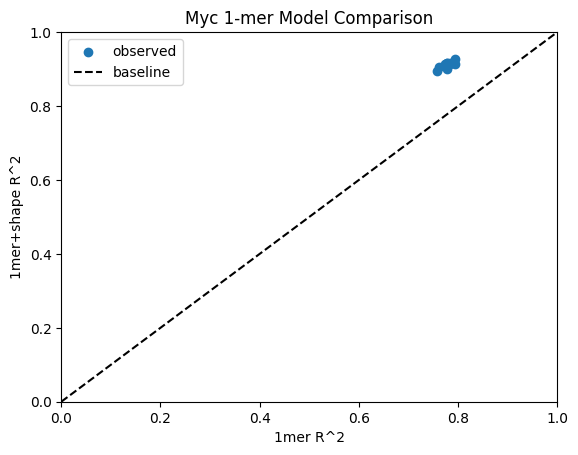

In [15]:
plt.scatter(myc_1mer, myc_1mer_shape, label='observed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('1mer R^2')
plt.ylabel('1mer+shape R^2')
plt.title('Myc 1-mer Model Comparison')
plt.plot([0,1], [0,1], '--', color='black', label='baseline')
plt.legend()
plt.show()

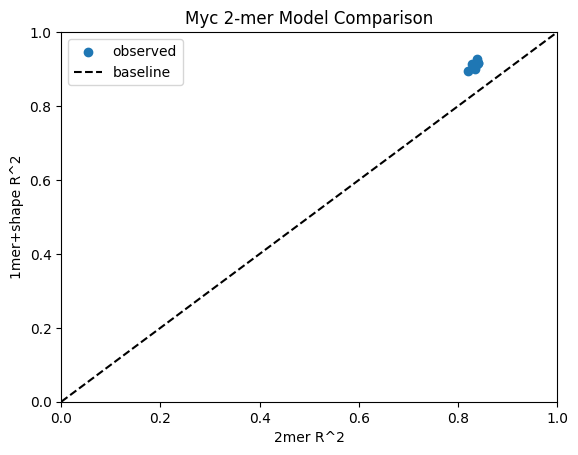

In [16]:
plt.scatter(myc_2mer, myc_1mer_shape, label='observed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('2mer R^2')
plt.ylabel('1mer+shape R^2')
plt.title('Myc 2-mer Model Comparison')
plt.plot([0,1], [0,1], '--', color='black', label='baseline')
plt.legend()
plt.show()

Repeat the process outlined in Q1 for ChIP-seq data (ctcf_bound.fasta and ctcf_unbound.fasta)
for the CTCF TF from Mus musculus. Build logistic regression models for the “1-mer”, “2-mer”
and “1-mer+shape” features, Plot the ROC curves for each model and calculate the AUC score for
each curve. Briefly discuss what you have learned from the results. [2pt]

**The ROC curves and the average AUC scores are similar across all three models, with an AUROC between 0.95 and 0.96 and a relatively small Std. Dev. AUROC of less than 0.01. This is suprising compared to the evidently superior results for the 1mer+shape model in the multiple linear regression task. However, it does not contradict the fact that adding shape features is likely to yield a superior model because linear regression predicts affinity scores which are continuous values whereas classification can only predict if a factor will bind or not. Adding shape features may still improve the model's predictive ability (as evidenced by superior R^2 in linear regression) but the gains may not be substantial enough to increase an already excellent AUROC value in the classification task.**

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [18]:
def shape_classifier(name, df, shape):
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    X = X = np.column_stack([df['1mer'].tolist(), shape])
    y = df['label'].values
    auroc_values = []; tpr_values = [[] for i in range(1000)]; fpr_values = [[] for i in range(1000)]
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    model = Ridge(alpha=0.001)
    
    for train_index, valid_index in cv.split(X):
        X_train, X_test = X[train_index], X[valid_index]
        y_train, y_test = y[train_index], y[valid_index]
        model.fit(X_train, y_train)
        
        # Predict probabilities on the test set
        y_pred_proba = model.predict(X_test) 
        
        # Calculate ROC curve and AUROC on the test set
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        auroc = roc_auc_score(y_test, y_pred_proba)
        auroc_values.append(auroc)
        for idx, value in enumerate(tpr):
            tpr_values[idx].append(value)
        for idx, value in enumerate(fpr):
            fpr_values[idx].append(value)
            
    std_tpr = np.array([np.std(values) for values in tpr_values if values]) 
    std_fpr = np.array([np.std(values) for values in fpr_values if values])
    mean_tpr = np.array([np.mean(values) for values in tpr_values if values]) 
    mean_fpr = np.array([np.mean(values) for values in fpr_values if values])
    mean_auroc = np.mean(auroc_values)
    std_auroc = np.std(auroc_values)
    
    # Plot AUROC curve
    plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'ROC curve (area = {mean_auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'Baseline')
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label=f'± 1 std. dev. (Average SD = {np.mean(std_tpr):.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name} Model')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f'Mean AUROC: {mean_auroc}; Std. Dev. AUROC: {std_auroc}') 

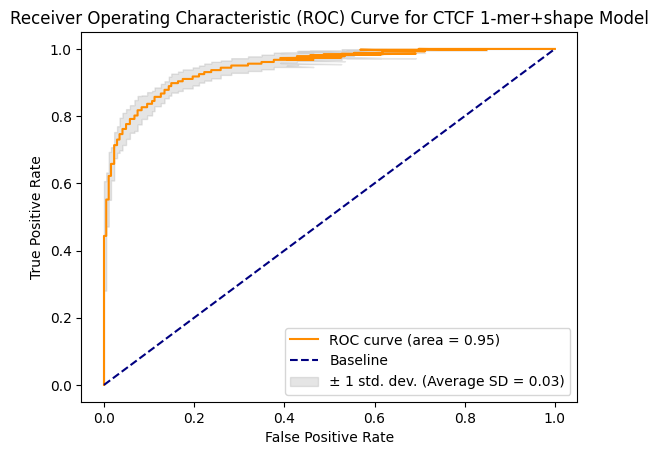

Mean AUROC: 0.9507072730085204; Std. Dev. AUROC: 0.00727206117877573


In [19]:
shape_classifier('CTCF 1-mer+shape', ctcf_seqs, ctcf_all)

In [20]:
def onemer_classifier(name, df):
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    X = X = np.array(df['1mer'].tolist())
    y = df['label'].values
    auroc_values = []; tpr_values = [[] for i in range(1000)]; fpr_values = [[] for i in range(1000)]
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    model = Ridge(alpha=0.001)
    
    for train_index, valid_index in cv.split(X):
        X_train, X_test = X[train_index], X[valid_index]
        y_train, y_test = y[train_index], y[valid_index]
        model.fit(X_train, y_train)
        
        # Predict probabilities on the test set
        y_pred_proba = model.predict(X_test) 
        
        # Calculate ROC curve and AUROC on the test set
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        auroc = roc_auc_score(y_test, y_pred_proba)
        auroc_values.append(auroc)
        for idx, value in enumerate(tpr):
            tpr_values[idx].append(value)
        for idx, value in enumerate(fpr):
            fpr_values[idx].append(value)
            
    std_tpr = np.array([np.std(values) for values in tpr_values if values]) 
    std_fpr = np.array([np.std(values) for values in fpr_values if values])
    mean_tpr = np.array([np.mean(values) for values in tpr_values if values]) 
    mean_fpr = np.array([np.mean(values) for values in fpr_values if values])
    mean_auroc = np.mean(auroc_values)
    std_auroc = np.std(auroc_values)
    
    # Plot AUROC curve
    plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'ROC curve (area = {mean_auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'Baseline')
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label=f'± 1 std. dev. (Average SD = {np.mean(std_tpr):.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name} Model')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f'Mean AUROC: {mean_auroc}; Std. Dev. AUROC: {std_auroc}') 

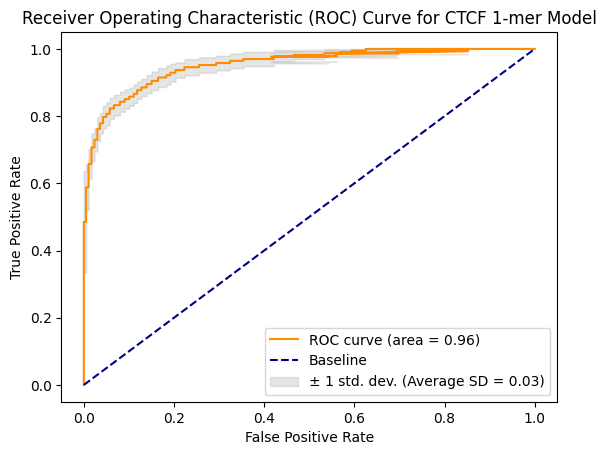

Mean AUROC: 0.9560108189469657; Std. Dev. AUROC: 0.008199877331214417


In [21]:
onemer_classifier('CTCF 1-mer', ctcf_seqs)

In [22]:
def twomer_classifier(name, df):
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    X = X = np.array(df['2mer'].tolist())
    y = df['label'].values
    auroc_values = []; tpr_values = [[] for i in range(1000)]; fpr_values = [[] for i in range(1000)]
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    model = Ridge(alpha=0.001)
    
    for train_index, valid_index in cv.split(X):
        X_train, X_test = X[train_index], X[valid_index]
        y_train, y_test = y[train_index], y[valid_index]
        model.fit(X_train, y_train)
        
        # Predict probabilities on the test set
        y_pred_proba = model.predict(X_test) 
        
        # Calculate ROC curve and AUROC on the test set
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        auroc = roc_auc_score(y_test, y_pred_proba)
        auroc_values.append(auroc)
        for idx, value in enumerate(tpr):
            tpr_values[idx].append(value)
        for idx, value in enumerate(fpr):
            fpr_values[idx].append(value)
            
    std_tpr = np.array([np.std(values) for values in tpr_values if values]) 
    std_fpr = np.array([np.std(values) for values in fpr_values if values])
    mean_tpr = np.array([np.mean(values) for values in tpr_values if values]) 
    mean_fpr = np.array([np.mean(values) for values in fpr_values if values])
    mean_auroc = np.mean(auroc_values)
    std_auroc = np.std(auroc_values)
    
    # Plot AUROC curve
    plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'ROC curve (area = {mean_auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'Baseline')
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label=f'± 1 std. dev. (Average SD = {np.mean(std_tpr):.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name} Model')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f'Mean AUROC: {mean_auroc}; Std. Dev. AUROC: {std_auroc}') 

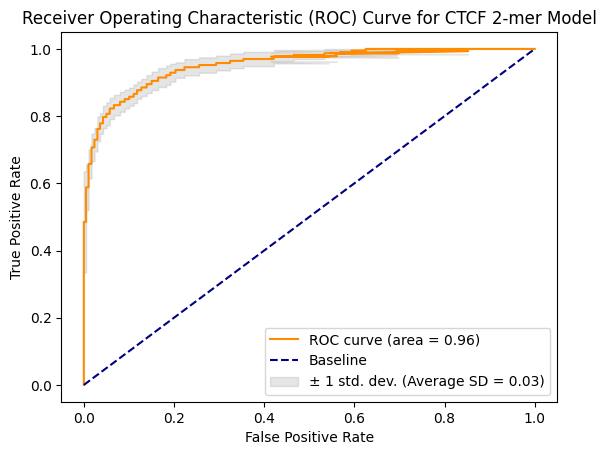

Mean AUROC: 0.9560108189469657; Std. Dev. AUROC: 0.008199877331214417


In [23]:
onemer_classifier('CTCF 2-mer', ctcf_seqs)